# Detection of parked cars in the city of Granada.
## Image segmentation using deep learning techniques.
### Notebook 3.3: Segmentation Model using DeepLabV3+.

### Authors:
- **Luis Crespo Orti**
- **Isabel María Moreno Cuadrado**
- **Pablo Olivares Martínez**
- **Ximo Sanz Tornero**

# 1. Import libraries and functions

In [1]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b612687371630237a23c899daa2fb4cf720abc1423d1b1825b14345bda6c00ef
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a366d5dd293f8c61446248e4adf094851cb058c71f7201d19266caa32135d8e1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we display the graphic card we are using and subsequently confirm the availability of the GPU. This step is taken to ensure that we do not default to using the CPU, as doing so would result in significantly higher time costs. We have previously installed the Torch library for NVIDIA GPUs on Linux, which includes CUDA acceleration, for the local executions we have conducted. Ultimately, however, the entire collaboration has been executed in google collab.

In [4]:
!nvidia-smi

Sat Jan 13 10:35:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


### Function to Display Evaluation Metrics

This function, `plot_metrics`, developed by Ignacio Oguiza and detailed in his [forum post](https://forums.fast.ai/t/plotting-metrics-after-learning/69937), is an extension for the `Recorder` class in FastAI. 

The function neatly organizes and displays the training metrics, leveraging the power of matplotlib for visualization. By stacking the values recorded during training and extracting the relevant metric names, it dynamically adjusts the number of rows and columns for the subplot based on the quantity of metrics to be displayed. This dynamic layout ensures that the visual representation is both clear and concise, regardless of the number of metrics.

Special attention is paid to aesthetics and clarity in the graph. Different colors are used to distinguish between training and validation metrics, enhancing the visual appeal and readability. The function also includes a check to hide any extra subplot axes, maintaining a neat presentation.

This utility is particularly useful for model evaluation in machine learning workflows, providing a quick and comprehensive view of performance metrics across both training and validation phases.


In [6]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### Function to Save Metrics to a CSV File

In our project, we have implemented a function `save_metrics_to_csv` that serves the crucial purpose of exporting training metrics to a CSV file. This functionality enhances data analysis and record-keeping capabilities for machine learning models.

The function takes a `learner` object from the FastAI library and a file path, defaulting to 'unet_metrics.csv', as inputs. By accessing the `recorder` attribute of the learner, it retrieves the stacked array of metric values and their corresponding names.

The core of the function lies in its ability to write these metrics into a CSV file. It begins by creating a file at the specified path and then proceeds to write the headers, which are the names of the metrics, followed by the metric values for each epoch. This process not only captures the numerical essence of the training process but also organizes it in a universally readable format.

This utility proves to be particularly beneficial for long-term tracking and analysis of model performance over multiple training epochs. It facilitates easy sharing and reviewing of results, thus serving as an indispensable tool for collaborative and iterative machine learning development processes. The function culminates by printing a confirmation message, indicating the successful saving of metrics to the specified file path.

In [7]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write headers (name of each metric)
        writer.writerow(['epoch'] + names)

        # Write the metric value each epoch
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

# 2. Preparation of the data.

In [8]:
path_to_dataset = Path('/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train')

In [9]:
def get_y_fn(x):
    """
    Given the image route, it returns it's corresponding mask
    """
    return Path(str(x).replace('src', 'gt').replace('.JPG', '.png'))


def get_items(path):
    """
    Obtains a list of every image in the 'src' folder
    """
    return get_image_files(path/'src')

# Comprehensive Guide to Mask Normalization and Denormalization Functions

## Function to Normalize Masks

The `normalize_mask` function is a crucial component in image processing, particularly in the context of semantic segmentation in computer vision. It transforms an RGB mask image into a class mask, where each pixel's class is represented by a unique value.

### Key Functionalities:
- **Input Validation**: It checks if the input mask is an RGB image with three color channels. If not, it raises a ValueError, ensuring that only correctly formatted masks are processed.
- **Class Mask Creation**: The function creates a zero-initialized array (`mask_class`) of the same height and width as the input mask, but with a single channel, to store class values.
- **Color-to-Class Mapping**: For each unique color defined in the `mapping` dictionary (where colors are keys and class values are values), the function locates pixels in the original mask that match the color and assigns the corresponding class value to those pixels in `mask_class`.

## Function to Denormalize Masks

The `denormalize_mask` function performs the reverse operation of `normalize_mask`. It converts a class mask back into an RGB mask, which is useful for visualizing the segmentation results.

### Key Functionalities:
- **Inverse Mapping**: It first creates an inverse mapping from class values to colors.
- **Color Mask Creation**: Similar to `normalize_mask`, it initializes a zero-valued RGB mask (`mask_color`).
- **Class-to-Color Conversion**: The function iterates over each unique class value in `mask_class`, retrieves the corresponding color from the inverse mapping, and applies this color to all pixels of that class in the new RGB mask.

## Mapping Colors for Class Normalization

The `mapping_class_color` dictionary is critical for both normalization and denormalization processes. It defines the correspondence between specific RGB colors and class values, which are used to identify different segments in the image, such as roads, cars, and background.

## Function to Obtain the Normalized Mask

The `get_mask` function integrates the normalization process into a workflow. It retrieves the mask path for a given item, loads the RGB mask as a


In [10]:
# Definition of the function to normalize masks
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definition of the function to denormalize masks
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapping colors for the class normalization
mapping_class_color = {
    (107, 142, 35): 0,  # Clase 0 - Background
    (102, 102, 156): 0,  # Clase 0
    (128, 64, 128): 1,  # Clase 1 - Road
    (0, 0, 142): 2,  # Clase 2 - Car
    (0, 0, 0): 0,     # Clase 0
}

# Function to obtain the normalized mask
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))
    return PILMask.create(normalize_mask(msk, mapping_class_color))

# Custom Shadow Transformation for Enhanced Image Processing

Our team used an innovative solution, the `ShadowTransform` class and its supporting function `add_shadow`, to enhance the robustness of our image processing pipeline. This custom implementation was specifically tailored to address the challenges posed by the Granada dataset, known for its numerous shadows with poor resolution, which significantly differ from the conditions in our earlier tested region in China.

## Design and Functionality of `add_shadow`

The `add_shadow` function is ingeniously crafted to artificially introduce shadows into images. This addition was crucial to simulate the variable lighting conditions commonly found in Granada, thus enabling our model to better generalize and perform under diverse environmental conditions.

### Key Features:
- **Dynamic Shadow Generation**: It creates multiple shadows (controlled by `num_shadows`) with varying shapes by randomly generating polygons within the image dimensions.
- **Realism through Opacity Variance**: The function randomly sets the opacity of each shadow (between `min_opacity` and `max_opacity`), adding a layer of realism to the simulated shadows.
- **Sophisticated Blending Technique**: By employing `cv2.addWeighted`, the shadows are seamlessly blended into the original image, ensuring that the shadows appear natural and are integral to the scene.

## The `ShadowTransform` Class

The `ShadowTransform` class, derived from `Transform`, encapsulates the shadow addition functionality and integrates it into our data processing pipeline. This class serves as a custom transformation specifically tailored for our machine learning models.

### Integration and Flexibility:
- **Parameter Customization**: It allows for easy adjustment of the number of shadows and their opacity range, enabling fine-tuning to match specific dataset characteristics.
- **Seamless Integration**: As a subclass of `Transform`, it can be effortlessly incorporated into standard data augmentation workflows in machine learning pipelines, particularly those involving image data.

## Impact and Performance

This custom shadow transformation significantly improved our model's performance not only in the Granada dataset but also showed surprising benefits in the Chinese dataset. By introducing variability in lighting conditions through artificial shadows, our model gained enhanced adaptability and robustness, leading to improved accuracy and generalization across diverse datasets.

In summary, the `ShadowTransform` and `add_shadow` are exemplary of our team's innovative approach to tackling specific challenges in image processing. This custom solution not only addressed the immediate needs of our project but also contributed to the broader field of computer vision by providing a novel method for enhancing dataset variability and model robustness. Our approach demonstrates the importance of dataset-specific customizations in achieving superior performance and adaptability in machine learning applications.

In [11]:
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

# Data Augmentation and Transformation Strategy for Model Training

In our project, we've employed a comprehensive set of data transformations within our DataBlock, drawing inspiration from the successful practices of renowned architectures like AlexNet. Our goal is to enhance our model's performance by introducing a diverse range of augmented data, simulating various real-world conditions.

## Default Augmentations: `aug_transforms`
We use `aug_transforms` to apply a suite of standard augmentation techniques:
- **Scaling**: Magnification is controlled with `mult=2`, `min_zoom=0.8`, and `max_zoom=3.0`.
- **Flipping**: Both horizontal (`do_flip=True`) and vertical flips (`flip_vert=True`) are enabled.
- **Rotation**: Images can be rotated up to `max_rotate=90` degrees.
- **Lighting Adjustments**: `max_lighting=0.2` to simulate different lighting conditions.
- **Perspective Warping**: `max_warp=0.2` introduces realistic distortions.
- **Probability Controls**: `p_affine=0.75` and `p_lighting=0.75` control the frequency of affine and lighting transformations, respectively.
- **Additional Parameters**: `mode='bilinear'`, `pad_mode='reflection'`, and `align_corners=True` ensure high-quality transformations.

## Custom Shadow Transformation
We integrate our custom `ShadowTransform`:
- Adds realistic shadows (`num_shadows=3`) with varying opacities (`min_opacity=0.5`, `max_opacity=0.75`).
- Enhances the model's ability to handle images with varying light conditions and shadow intensities.

## DataBlock Configuration
- **Number of Classes**: `num_classes = 3`, defining the granularity of our segmentation task.
- **DataBlock Format**: Composed of `ImageBlock` and `MaskBlock` with `num_classes`.
- **Data Retrieval**: `get_items` and `get_mask` functions for fetching images and corresponding masks.
- **Data Splitting**: `RandomSplitter` with a 10% validation set (`valid_pct=0.1`) and a fixed seed for reproducibility.
- **Item and Batch Transformations**: `Resize(256,384)` at item level and a combination of default and custom augmentations at the batch level.
- **Normalization**: `Normalize.from_stats(*imagenet_stats)` standardizes the images based on ImageNet statistics.

## DataLoader and Visualization
- **DataLoader Creation**: `dataloaders` method generates DataLoaders with a batch size of 32.
- **Visualization**: `show_batch` displays a batch of training data, allowing us to visually inspect the applied transformations.

By integrating a rich set of transformations, both standard and custom, we aim to robustly train our model, ensuring it can generalize well across diverse scenarios. This approach is heavily influenced by the principles seen in models like AlexNet, where diverse data exposure led to significant performance gains. Our tailored transformations specifically address the unique challenges of our dataset, aiming to surpass the effectiveness of standard models.```


In [12]:
# Default transformations
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True,
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0,
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75,
                                p_lighting=0.75, xtra_tfms=None, size=None,
                                mode='bilinear', pad_mode='reflection',
                                align_corners=True, batch=False, min_scale=1)

# Aspect ratio of 3:2 for Dataset Optimization

In our data transformation pipeline, we've incorporated a crucial element: resizing all images to a 3:2 aspect ratio with a size of 256x384 pixels. This choice was driven by the uniform aspect ratio represented in our dataset of 1.667 and 1.7. Furthermore, Fastai resize function losses information about borders when resizing. Therefore this ratio maximizes the information which we can get about an image. Further explanation is presented in the paper.

## GPU VRAM Consideration
The decision to resize images to 256x384 pixels was influenced by GPU memory constraints. This size strikes a balance between model performance and GPU VRAM limitations. It allows us to efficiently train our model on available hardware resources while maintaining a reasonable image resolution for accurate segmentation.

In summary, our choice to resize images to a square aspect ratio of 256x384 pixels was driven by a combination of datasets requirements and practical considerations related to GPU memory. This ensures that our model is both compatible with the FastAI framework and capable of efficient training on available hardware.

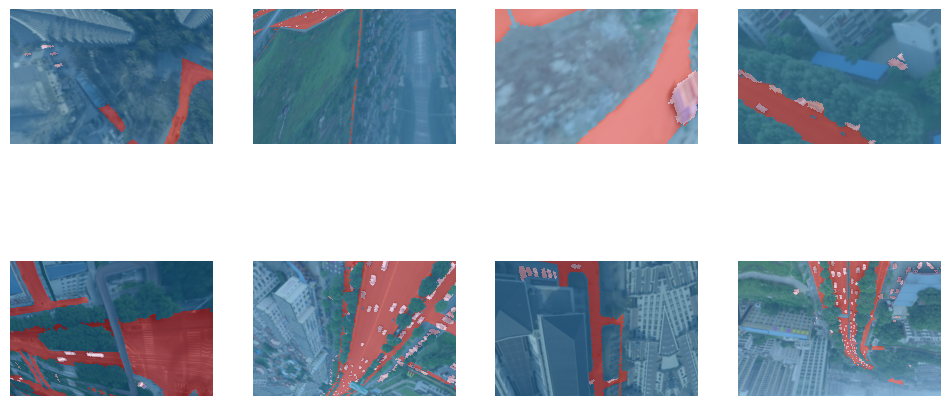

In [13]:
# Define the number of classes in our dataset
num_classes = 3

# Define the format of our datablock
data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=Resize((256, 384)),
    batch_tfms=[*aug_transforms, ShadowTransform(
        num_shadows=3, min_opacity=0.5, max_opacity=0.75), Normalize.from_stats(*imagenet_stats)]
)

# Create a dataloader and show a batch
dls = data.dataloaders(path_to_dataset, bs=32)
dls.train.show_batch(max_n=8)

In [14]:
# We see the shape of a batch to see that everything is correct
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([32, 3, 256, 384]), torch.Size([32, 256, 384]))

# Visualization of Original and Normalized Masks

In this code segment, we focus on the visual aspect of mask processing, primarily for the purpose of visualization and understanding. The provided code showcases the steps for loading and normalizing masks, enhancing our comprehension of the data.

## Loading and Displaying the Original Mask
We initiate the process by defining the `path_to_image` variable, which should be substituted with the actual path to the image file containing the mask. The `get_y_fn` function assists in obtaining the path to the corresponding mask.

Subsequently, we load the original mask using `PILImage.create` and present it visually using `plt.imshow`. This step is invaluable for gaining insights into the raw mask's content, allowing us to observe the segmentation information it contains.

## Applying Normalization for Enhanced Visualization
To further our understanding and visualization capabilities, we apply the normalization process. The `normalize_mask` function is employed, taking the original mask (in the form of a numpy array) and a color-to-class mapping (`mapping_class_color`) as inputs.

The result is a normalized mask represented in grayscale, displayed using `plt.imshow`. This presentation aids in comprehending the transformation of the mask and the color-to-class mappings, enabling a more intuitive interpretation of the segmentation data.

While this code serves a crucial role in visualization, it also lays the foundation for subsequent data analysis and model training, ensuring that our masks are appropriately prepared for downstream tasks in our computer vision project.


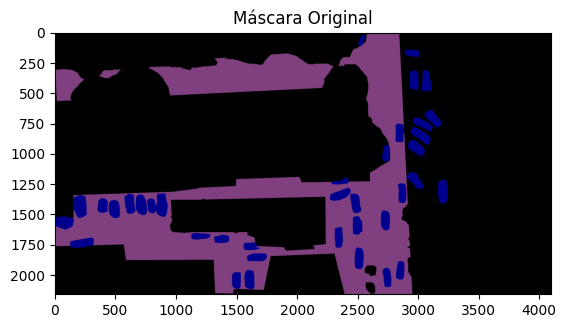

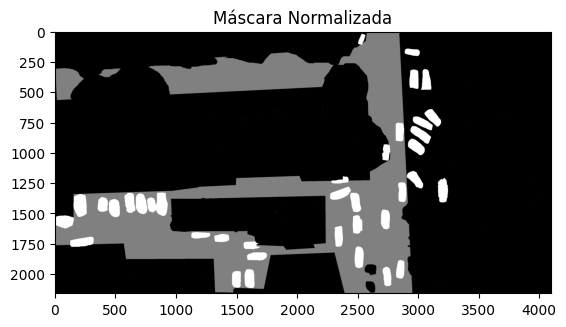

In [15]:
path_to_image = '/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train/src/001401.JPG'  
mask_path = get_y_fn(path_to_image)

# Original mask
original_mask = PILImage.create(mask_path)
plt.imshow(original_mask)
plt.title("Máscara Original")
plt.show()

# Normalization applied
normalized_mask = normalize_mask(np.array(original_mask), mapping_class_color)
plt.imshow(normalized_mask, cmap='gray')
plt.title("Máscara Normalizada")
plt.show()

# 3. Implementation of the model.

### DeepLabV3+ Implementation Overview

In this implementation, we initialize a DeepLabV3+ model, a powerful architecture for semantic segmentation. DeepLabV3+ is renowned for its ability to capture multi-scale context and maintain high-resolution information simultaneously.

**Key Components of the Implementation:**
- **Encoder Weights:** Pre-trained weights (`ENCODER_WEIGHTS`) from ImageNet are utilized to initialize the backbone (ResNet-101), enhancing the model's feature recognition capabilities.
- **Number of Classes:** The variable `CLASSES` (set to `num_classes`) defines the number of target classes for segmentation, providing flexibility for various segmentation tasks.

**Comparison with U-Net and PSPNet:**

- **Architecture Differences:** DeepLabV3+ stands out with its emphasis on atrous convolutions and spatial pyramid pooling, allowing it to capture multi-scale context effectively while maintaining spatial detail. In contrast, U-Net focuses on preserving fine-grained details with skip connections, and PSPNet uses pyramid pooling to aggregate context at different scales.
- **Performance:** DeepLabV3+ excels in scenarios where maintaining both high-resolution details and capturing context across different scales are critical. U-Net is preferred for precise boundary delineation and fine-grained segmentation, while PSPNet shines in maintaining label consistency across large regions.
- **Use-Cases:** DeepLabV3+ is often chosen for urban scene segmentation, where both fine details and contextual information are essential. U-Net is well-suited for medical image segmentation tasks, emphasizing boundary accuracy, while PSPNet is valuable for complex scene parsing where label consistency matters.

In summary, the DeepLabV3+ implementation offers a robust solution for tasks requiring simultaneous multi-scale context and high-resolution segmentation. However, the choice between DeepLabV3+, U-Net, and PSPNet should be made based on specific project requirements, including the need for context preservation, fine details, or label consistency in segmentation tasks.


In [16]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = num_classes
ACTIVATION = None

# Implementation of the model DeepLabV3+
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 75.8MB/s]


# Comprehensive Model Configuration and Evaluation Strategy

In this code snippet, we embark on a journey of configuring a segmentation model, assessing its performance, and optimizing it for our specific computer vision task. Several critical aspects are worth highlighting:

## Backbone Selection: `resnet101`
Our choice of the `resnet101` architecture as the backbone for our segmentation model signifies a strategic decision. ResNet-101 is renowned for its depth and impressive feature extraction capabilities. By leveraging this architecture, we benefit from deep feature representations, enabling the model to capture intricate details in the images. This choice proves advantageous when dealing with complex segmentation tasks, as it allows the model to learn and represent nuanced patterns and structures in the data.

## In-Depth Analysis of Backbone Selection: `resnet101`

The choice of the `resnet101` architecture as the backbone for our segmentation model deserves a closer examination. This decision was made after careful consideration of several backbone options, and it is pivotal to the success of our computer vision task. Let's delve deeper into why `resnet101` stands out and how it compares to other possible backbones.

## ResNet-101: A Deep and Powerful Backbone
`resnet101` is a member of the ResNet (Residual Network) family, and it is celebrated for its depth and capabilities. Here are key attributes that make it a compelling choice:

### 1. Depth and Feature Hierarchy
ResNet-101 is exceptionally deep, featuring 101 layers. This depth allows the model to learn increasingly abstract and hierarchical features from the input data. As a result, it can capture intricate details, patterns, and textures in the images. This depth is particularly advantageous for complex segmentation tasks where fine-grained distinctions are crucial.

### 2. Residual Connections
The core innovation of ResNet architectures is the inclusion of residual connections. These skip connections enable the network to circumvent vanishing gradient problems, facilitating the training of very deep networks. Residual connections also contribute to feature reuse and transferability, making the model more effective at feature extraction and representation.

### 3. Pretrained Weights
`resnet101` can be initialized with weights pretrained on large-scale datasets such as ImageNet. This pretraining imparts the model with knowledge of a wide range of visual concepts, allowing it to leverage this prior knowledge when fine-tuning on our specific segmentation task. This transfer learning aspect is instrumental in achieving strong performance even with limited annotated data.

## Comparison with Other Backbones
While `resnet101` offers several advantages, it's worth acknowledging that the choice of a backbone depends on various factors, including the nature of the dataset and the specific requirements of the task. Here's a brief comparison with other common backbones:

### 1. `resnet50` vs. `resnet101`
- `resnet50` is shallower with 50 layers compared to `resnet101`'s 101 layers. It may be more memory-efficient and quicker to train but may not capture as fine-grained details.
- `resnet101` excels in tasks where intricate feature extraction is paramount, making it ideal for demanding segmentation tasks.

### 2. Custom Architectures
- Designing custom architectures tailored to the specific segmentation task is an option. This approach allows for complete control but may require extensive experimentation and data to achieve competitive results.

### 3. Other Architectures
- Architectures like U-Net, VGG16, and MobileNet are viable alternatives, each with its own strengths and weaknesses. U-Net, for instance, is known for its skip connections and suitability for segmentation tasks.

In conclusion, `resnet101` was chosen as the backbone for its depth, feature hierarchy, and pretrained weights, which are instrumental in tackling our complex segmentation task. While other backbones have their merits, `resnet101` aligns well with our goals of achieving accurate and detailed object segmentation in our computer vision application.

## Metrics for Performance Assessment
To comprehensively assess the model's performance, we employ a combination of metrics:

- **Foreground Accuracy (foreground_acc)**: This metric, implemented in fastai as `foreground_acc(inp, targ, bkg_idx=0, axis=1)`, computes the non-background accuracy for multiclass segmentation tasks. It focuses on accurately identifying and evaluating the segmentation of the foreground objects, providing insights into the model's ability to delineate objects of interest.

  The mathematical function for `foreground_acc` can be described as follows:

  ```python
  # Pseudo-code representation of the mathematical function
  inp: Predicted segmentation tensor
  targ: Target segmentation tensor
  bkg_idx: Index representing the background class (default is 0)
  axis: Axis along which to calculate accuracy (default is 1)

  # Calculate non-background accuracy
  non_bg_acc = (inp != bkg_idx) & (inp == targ)
  foreground_accuracy = non_bg_acc.sum() / (inp != bkg_idx).sum()


  This metric provides a measure of how accurately the model identifies and segments foreground objects, ignoring the background class.

- **Dice Similarity Coefficient (DiceMulti())**: The Dice coefficient quantifies the overlap between predicted and ground-truth masks using the formula:

  $$
  \text{Dice}(A, B) = \frac{2 \cdot |A \cap B|}{|A| + |B|}
  $$

  Its multi-class variant, `DiceMulti()`, extends this evaluation to multiple classes, enhancing the model's suitability for multi-class segmentation tasks.

- **Jaccard Coefficient (JaccardCoeffMulti())**: Similar to the Dice coefficient, the Jaccard coefficient assesses the overlap between predicted and true masks using the formula:

  $$
  \text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
  $$

  It offers an alternative perspective on segmentation quality, complementing the Dice coefficient in performance assessment.


By combining these metrics, we gain a holistic view of the model's performance, addressing various aspects of segmentation accuracy and overlap. This comprehensive assessment ensures that our model excels in accurately segmenting objects across different classes, which is crucial for our specific application.

<!-- Focal Loss Function: A Powerful Tool for Semantic Segmentation -->

The Focal Loss function, introduced by Lin et al. in their paper titled "Focal Loss for Dense Object Detection," is a critical component in modern semantic segmentation tasks. It addresses some of the challenges posed by class imbalance and helps improve the performance of deep learning models in these tasks.

**Focal Loss Definition:**

The Focal Loss function is defined as:

$$
\mathcal{L}(\hat{y}, y) = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$

where $\hat{y}$ is the predicted probability distribution, $y$ is the true probability distribution and $N$ is the number of classes. This function basically penalizes the model when it predicts a low probability for the true class.

**Advantages of Focal Loss:**

1. **Addressing Class Imbalance:** Focal Loss is particularly effective in scenarios where class imbalance exists. In semantic segmentation, some classes may have significantly fewer pixels or instances compared to others, like our case with cars and roads compared to background. The Focal Loss function dynamically adjusts the loss contribution for each class based on their prediction probabilities. It assigns higher importance to hard-to-predict classes, helping the model focus on improving its performance on these challenging classes.

2. **Reducing the Impact of Easy Samples:** Conventional loss functions like cross-entropy treat all samples equally. In segmentation tasks, there are typically many more background (non-object) pixels than object pixels. Focal Loss reduces the influence of easy-to-classify background pixels, preventing the model from becoming overwhelmed by them and focusing on correctly classifying the foreground objects.

3. **Improved Model Robustness:** By addressing class imbalance and emphasizing hard examples, Focal Loss can lead to more robust models. It can handle situations where some classes may be underrepresented in the training data or where object instances are small and challenging to detect.

4. **Better Convergence:** Focal Loss often leads to faster convergence during training. The reduction in the loss contribution from easily classifiable samples encourages the model to prioritize learning from more informative examples.

5. **Enhanced Performance:** Focal Loss has been widely adopted in various computer vision tasks, including object detection and semantic segmentation, and has demonstrated improved segmentation accuracy and mIoU (mean Intersection over Union) scores.

In summary, the Focal Loss function is a powerful tool for addressing class imbalance and improving the performance of semantic segmentation models. Its ability to dynamically adjust the loss based on the difficulty of samples, reduce the impact of easy samples, and enhance model robustness makes it a compelling choice for many segmentation tasks. Researchers and practitioners often choose Focal Loss to boost the accuracy and reliability of their semantic segmentation models.


In [17]:
# Create an object type learner with DeepLab structure
learner = Learner(dls, model,loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

In [18]:
learner.summary() # Here we whow the model implementation

/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:390: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


DeepLabV3Plus (Input shape: 32 x 3 x 256 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 192 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 96   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 64 x 96  
Conv2d                                    16384      True      
BatchNorm2d                     

<!-- Learning Rate Finder: Optimizing Model Training -->

The `lr_find()` method plays a crucial role in the model training process. It's employed to determine an optimal learning rate (LR) for training the neural network. Here's why we use this method and how it helps us reach the minimum of the loss function:

## Why `lr_find()`?

1. **Learning Rate Sensitivity**: Neural networks are sensitive to the choice of learning rate. A learning rate that's too high can lead to divergent training, while one that's too low can result in slow convergence. `lr_find()` helps us identify the learning rate range where the model is most responsive to training.

2. **Efficiency**: Manually selecting an appropriate learning rate can be time-consuming and requires trial and error. `lr_find()` automates this process, saving valuable time and resources.

## How It Works

1. **Learning Rate Range**: `lr_find()` systematically varies the learning rate over a specified range, often using a logarithmic scale. It monitors the model's loss as the LR changes.

2. **Plotting the Results**: The method then generates a plot, referred to as a "learning rate curve," which shows the learning rate on the x-axis and the corresponding loss on the y-axis.

3. **Finding the Optimal LR**: By visually inspecting the learning rate curve, we can identify the learning rate at which the loss exhibits a steep decline or a minimum point. This LR is chosen as the optimal learning rate for training the model.

In summary, `lr_find()` is an indispensable tool for finding the learning rate that allows our model to converge efficiently to the minimum of the loss function. It automates the LR selection process, ensuring that our model's training process is both effective and time-efficient.


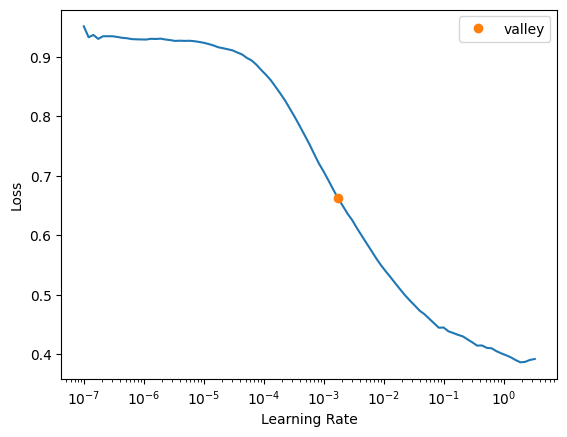

In [19]:
lr=learner.lr_find()

# 4. Model Training

### Model Training Methodology: Selection of fit_one_cycle

The decision to implement the `fit_one_cycle` method for training the model is rooted in extensive research and empirical evidence supporting its efficacy. This approach is renowned for its ability to train models rapidly and effectively, leveraging a cyclical learning rate policy that starts low, increases, and then decreases again. The policy aids in stabilizing the training process and preventing overfitting, which is crucial for achieving a high-performing model.

Numerous studies have demonstrated that `fit_one_cycle` not only helps in faster convergence but also promotes better generalization, which can be particularly beneficial in complex tasks such as image segmentation. By adjusting the learning rate throughout the training cycle, the method encourages the model to explore a broader range of solutions, ultimately leading to a more robust set of weights.

Further technical details and the underlying principles of the `fit_one_cycle` method, along with a comprehensive analysis of its impact on the training of the model, will be discussed in the paper.

### Analysis of DeepLabV3+ Performance During Training

#### Model Training Choice:
- **Epochs:** A regimen of 50 epochs was administered for the DeepLabV3+ model, aligning with industry standards for model training comparison. This consistency in epochs allows for equitable performance assessments.

#### Performance Analysis:
- **Train and Validation Loss:** Throughout the 50 epochs, we observed a general decrease in training loss, indicating that the model was learning effectively. However, the validation loss displayed some instability, which may suggest challenges in the model’s ability to generalize. This could be due to the high variability of the validation set or an overfitting to the training data in some epochs.

- **Accuracy Metrics:**
  - **Foreground Accuracy:** The foreground accuracy exhibited significant fluctuations but ultimately improved, particularly showing a substantial rise after the 10th epoch. This erratic pattern suggests variability in the complexity of the validation data or the model's sensitivity to certain data augmentations.
  - **Dice Multi and Jaccard Coefficients:** These important segmentation performance metrics initially showed some inconsistency but then followed an upward trajectory, indicating a trend toward improved segmentation precision as the model was further trained.

- **Validation vs. Training Performance:** The validation performance showed a varied pattern when compared to training performance. There were epochs where validation loss significantly exceeded training loss, which could highlight potential overfitting issues or represent a response to complex validation data transformations.

- **Time Efficiency:** The average time per epoch was around 03:35 minutes, with some variability. This variation in time could be attributed to the computational complexity of processing different batches of data or the varying efficiency of the data loader.

#### Conclusion:
- DeepLabV3+ demonstrates a capacity for improving key performance metrics over 50 epochs, such as foreground accuracy and segmentation coefficients, despite some inconsistency in validation loss.
- The fluctuating epoch durations and validation loss require further analysis to optimize the learning rate and improve training efficiency.
- The model's potential in generalizing and segmenting complex images is evident, but further refinements in training and data augmentation may be necessary to stabilize performance gains.


In [20]:
learner.fit_one_cycle(50,lr_max=lr[0])  

epoch,train_loss,valid_loss,foreground_acc,dice_multi,jaccard_coeff_multi,time
0,0.782622,0.461280,0.141232,0.339554,0.270931,04:55
1,0.606378,0.708437,0.188586,0.380797,0.303750,03:30
2,0.482521,1.171842,0.194305,0.375128,0.297416,03:28
3,0.389730,4.187215,0.373174,0.357179,0.260561,03:28
4,0.326919,0.929882,0.183949,0.423472,0.351509,03:30
5,0.280274,0.141477,0.568068,0.609033,0.498601,03:32
6,0.243614,0.393653,0.445107,0.606386,0.482131,03:29
7,0.217938,5.290905,0.018474,0.336850,0.300984,03:28
8,0.194786,0.124149,0.431782,0.610777,0.491231,03:33
9,0.179396,0.255008,0.852158,0.523392,0.392386,03:34


### Analysis of Performance Metrics for DeepLabV3+

#### Losses:
- **Train vs Validation Loss:** The training loss demonstrates a pronounced decline, signifying the model's effective learning from the data. Yet, the validation loss graph for DeepLabV3+ reveals sporadic spikes, likely reflecting the model's encounter with batches of more complex or diverse data. These spikes may suggest temporary instability in the optimization process, potentially caused by aggressive data augmentation strategies employed during training. Notably, specific sharp increases in validation loss at epochs 3 and 8 were observed. Although a loss function overflow could be hypothesized for these instances, this was ruled out considering the expected behavior of the training loss. These anomalies highlight the need for a careful calibration of the learning rate and underscore potential improvements in hyperparameter tuning. Despite these perturbations, DeepLabV3+ shows resilience, quickly rebounding to a path of improved generalization as evidenced by the decreasing trend over the course of the training epochs.

#### Foreground Accuracy (`foreground_acc`):
- **Validation Foreground Accuracy:** Displaying significant fluctuations, the foreground accuracy nonetheless maintains an upward trajectory. This improvement suggests the model's growing adeptness at identifying foreground objects within the validation images, in spite of the challenges presented by the diversity and complexity of the dataset.

#### Dice Coefficient (`dice_multi`):
- **Validation Dice Coefficient:** After initial volatility, the Dice coefficient exhibits a steady ascent, indicative of the model's enhanced segmentation accuracy. The continued rise reflects a maturing ability to segment images, affirming the model's increasing segmentation proficiency over time.

#### Jaccard Coefficient (`jaccard_coeff_multi`):
- **Validation Jaccard Coefficient:** Mirroring the Dice coefficient's trend, the Jaccard coefficient's overall increase suggests improvements in segmentation quality, with the model's predictions becoming more congruent with the actual image segmentations as training proceeds.


### Overall Assessment:

The training dynamics of DeepLabV3+ are complex, as indicated by the initial learning phase followed by a trend towards stabilization and enhanced segmentation capability. The model's robustness is evident from the consistent improvement in key segmentation metrics despite the intermittent spikes in validation loss. The training and validation loss curves' convergence by the end of the training suggests that the model is effectively learning from the training data while maintaining the ability to generalize to new data. These factors, combined with the resilience displayed in quickly overcoming optimization challenges, demonstrate the DeepLabV3+ model's strong potential for high-performance image segmentation tasks. Further details, including a nuanced discussion of the fit_one_cycle method and its successful application in our training regimen, will be elaborated in the accompanying paper.


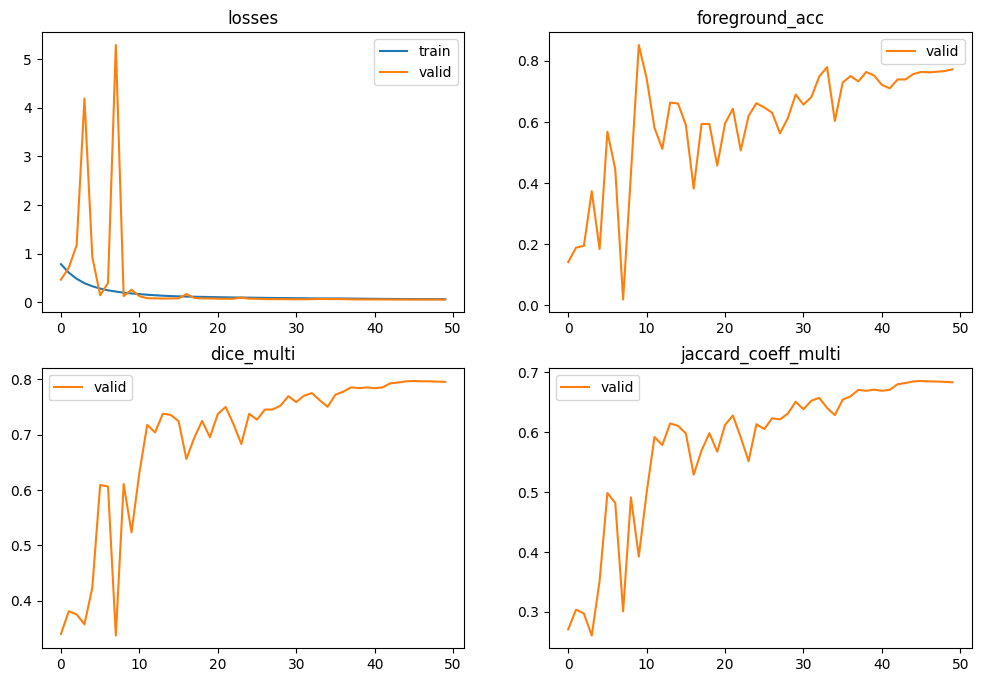

In [21]:
learner.recorder.plot_metrics()

In [22]:
learner.save('deeplab50') # We save the weights of our training so that we can use them in the future, this uses the implementation done by fastai.

Path('models/deeplab50.pth')

In [23]:
save_metrics_to_csv(learner, file_path='deeplab_metrics.csv')

Metrics saved to deeplab_metrics.csv


#### Visualizing Results with `learner.show_results()`:
- We use `learner.show_results()` to provide valuable insights into the model's predictions. This function allows us to inspect how well the model is segmenting images in our train dataset.

#### Conclusion:
- In conclusion, our analysis of the DeepLabV3 model has shown promising results in terms of improving metrics and efficient training. However, for a more comprehensive comparison, this model will be evaluated alongside others. As a result, this model will be the chosen one as it has shown more promising results than the others. By this reason we will find an optimum number of epoch to completely refine our model to the dataset without overfitting. This will be done in another notebook showing the results obtained in test.

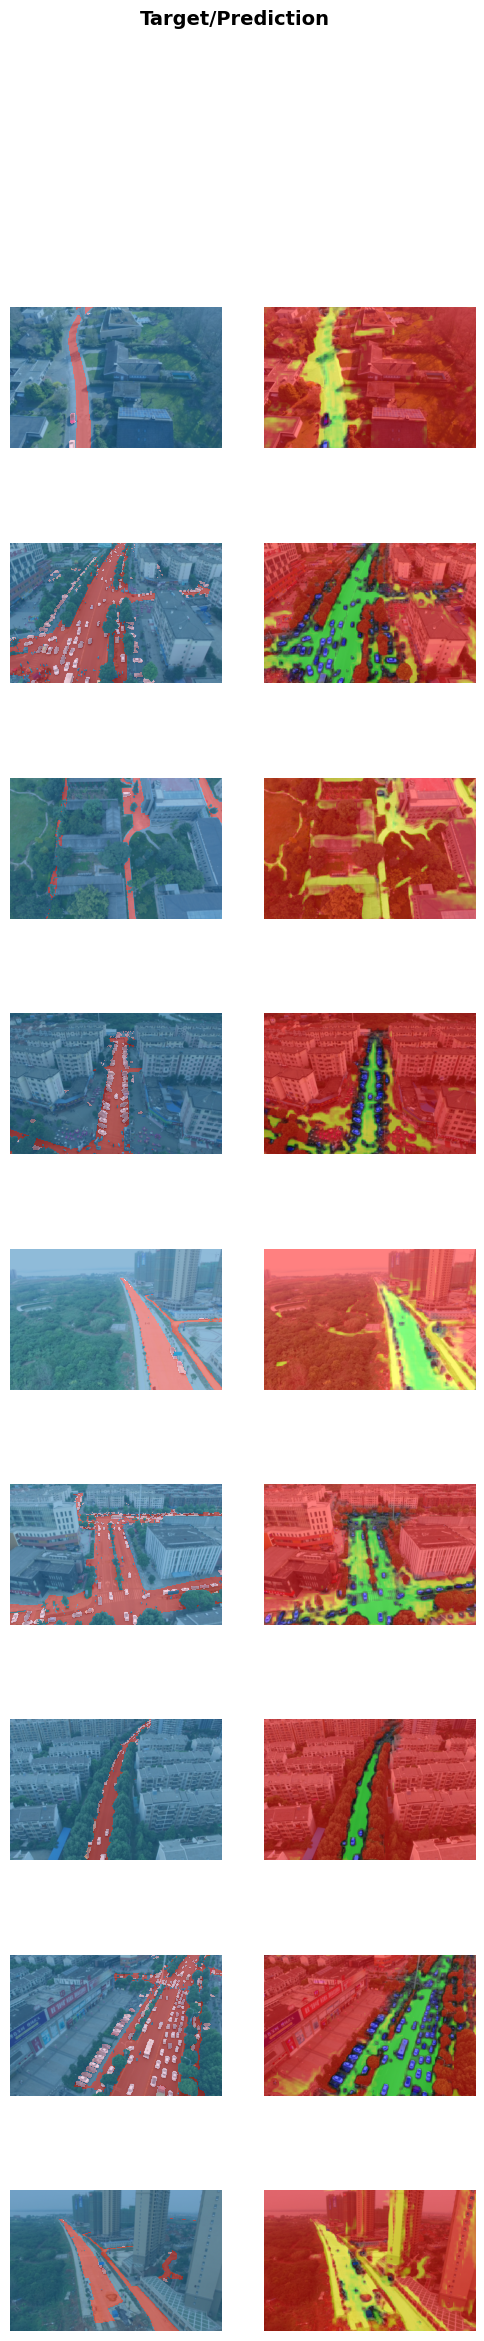

In [24]:
learner.show_results()

In [25]:
learner.export(fname='deeplab.pkl') # We save the weights of our training so that we can use them in the future, this uses the implementation done by pytorch.